In [1]:
import cv2, time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

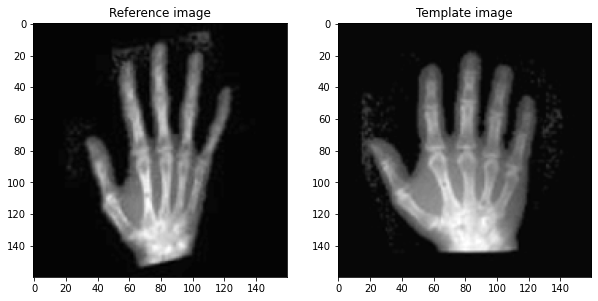

In [2]:
ref_img = cv2.imread('./Images/R1.png',32)
temp_img = cv2.imread('./Images/T1.png',32)
#temp_img = cv2.imread('./Images/t2_T.png',32)
#ref_img = cv2.imread('./Images/t2_R.png',32)
shape = min(min(ref_img.shape),min(temp_img.shape))//32*32
img_shape = (shape,shape)
ref_img = cv2.resize(ref_img,img_shape,interpolation=cv2.INTER_CUBIC)
temp_img = cv2.resize(temp_img,img_shape,interpolation=cv2.INTER_CUBIC)

# from 0-255 to 0-1
ref_img = np.float32((ref_img-np.min(ref_img))/(np.max(ref_img)-np.min(ref_img)))
temp_img = np.float32((temp_img-np.min(temp_img))/(np.max(temp_img)-np.min(temp_img)))

figure = plt.figure(figsize=(10,5))
figure.add_subplot(1,2,1)
plt.title('Reference image')
plt.imshow(ref_img,cmap='gray')
figure.add_subplot(1,2,2)
plt.title('Template image')
plt.imshow(temp_img,cmap='gray')
plt.show()

# Setup functions and model

In [3]:
# Dense image warp from Tensorflow addons
# There is an error using tfa.image.dense_image_warp
# define same tfa.image.dense_image_warp

from tensorflow_addons.utils import types
from typing import Optional

def _get_dim(x, idx):
    if x.shape.ndims is None:
        return tf.shape(x)[idx]
    return x.shape[idx] or tf.shape(x)[idx]

def dense_image_warp(
    image: types.TensorLike, flow: types.TensorLike, name: Optional[str] = None
) -> tf.Tensor:
    with tf.name_scope(name or "dense_image_warp"):
        image = tf.convert_to_tensor(image)
        flow = tf.convert_to_tensor(flow)
        batch_size, height, width, channels = (
            _get_dim(image, 0),
            _get_dim(image, 1),
            _get_dim(image, 2),
            _get_dim(image, 3),
        )

        # The flow is defined on the image grid. Turn the flow into a list of query
        # points in the grid space.
        grid_x, grid_y = tf.meshgrid(tf.range(width), tf.range(height))
        stacked_grid = tf.cast(tf.stack([grid_y, grid_x], axis=2), flow.dtype)
        batched_grid = tf.expand_dims(stacked_grid, axis=0)
        query_points_on_grid = batched_grid - flow
        query_points_flattened = tf.reshape(query_points_on_grid, [batch_size, height * width, 2])
        # Compute values at the query points, then reshape the result back to the
        # image grid.
        interpolated = tfa.image.interpolate_bilinear(image, query_points_flattened)
        interpolated = tf.reshape(interpolated, [batch_size, height, width, channels])
        return interpolated

In [4]:
def img_grad(img):
    # Image gradient by central difference
    dx = tf.pad((img[2:,:]-img[:-2,:])/2,paddings=([[1,1],[0,0]]))
    dy = tf.pad((img[:,2:]-img[:,:-2])/2,paddings=([[0,0],[1,1]]))
    return tf.stack([dx, dy], axis=0)

def exp_vec_field(vec_field,update_step_length):
    small_vec = 1*vec_field
    max_length_vec = tf.reduce_max(tf.norm(small_vec,axis=0))
    N = 0
    while max_length_vec>update_step_length:
        small_vec /= 2
        max_length_vec = tf.reduce_max(tf.norm(small_vec,axis=0))
        N+=1
    flow = tf.expand_dims(tf.transpose(small_vec,[1,2,0]),axis=0) #(1,img_shape[0],img_shape[1],2)
    for _ in range(N):
        flow += dense_image_warp(flow,-flow) #(1,img_shape[0],img_shape[1],2)
    return tf.transpose(flow[0],[2,0,1])

In [5]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=img_shape+(3,))

layer_names = ['block1_conv2','block2_conv2','block3_conv3','block4_conv3','block5_conv3']
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,name='down_stack')
down_stack.trainable = False

inputs = tf.keras.layers.Input(shape=img_shape+(3,))
# Downsampling through the model
skips = down_stack(inputs)
x = skips.pop()
skips = skips[::-1]
# Upsampling and establishing the skip connections
up = tf.keras.layers.UpSampling2D(2)

for skip in skips:
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
    x = tf.keras.layers.Conv2D(x.shape[3]/4,3,activation='relu',padding='same')(x)
x = tf.keras.layers.Conv2D(1,3,padding='same')(x)

heatmap_model = tf.keras.Model(inputs=inputs, outputs=x,name='heatmap_model')
heatmap_model.summary()
Wsave = heatmap_model.get_weights()

Model: "heatmap_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
down_stack (Functional)         [(None, 160, 160, 64 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    multiple             0           down_stack[0][4]                 
                                                                 conv2d[0][0]                     
                                                                 conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]       

In [6]:
'''base_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=img_shape+(3,))

layer_names = ['block2_pool','block3_pool','block4_pool','block5_pool']
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,name='down_stack')
down_stack.trainable = False

inputs = tf.keras.layers.Input(shape=img_shape+(3,))
# Downsampling through the model
skips = down_stack(inputs)
x = skips.pop()
skips = skips[::-1]
x = tf.keras.layers.Conv2D(4096, 1, activation='relu')(x)
x = tf.keras.layers.Conv2D(1, 1, activation='relu')(x)
# Upsampling and establishing the skip connections
for skip in skips:
    up = tf.keras.layers.UpSampling2D(2)
    x = up(x)
    skip_sum = tf.expand_dims(tf.reduce_sum(skip,axis=3),axis=-1)
    x += skip_sum

last = tf.keras.layers.UpSampling2D(4)
x = last(x)
heatmap_model = tf.keras.Model(inputs=inputs, outputs=x,name='heatmap_model')
heatmap_model.summary()
Wsave = heatmap_model.get_weights()'''

"base_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=img_shape+(3,))\n\nlayer_names = ['block2_pool','block3_pool','block4_pool','block5_pool']\nbase_model_outputs = [base_model.get_layer(name).output for name in layer_names]\ndown_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,name='down_stack')\ndown_stack.trainable = False\n\ninputs = tf.keras.layers.Input(shape=img_shape+(3,))\n# Downsampling through the model\nskips = down_stack(inputs)\nx = skips.pop()\nskips = skips[::-1]\nx = tf.keras.layers.Conv2D(4096, 1, activation='relu')(x)\nx = tf.keras.layers.Conv2D(1, 1, activation='relu')(x)\n# Upsampling and establishing the skip connections\nfor skip in skips:\n    up = tf.keras.layers.UpSampling2D(2)\n    x = up(x)\n    skip_sum = tf.expand_dims(tf.reduce_sum(skip,axis=3),axis=-1)\n    x += skip_sum\n\nlast = tf.keras.layers.UpSampling2D(4)\nx = last(x)\nheatmap_model = tf.keras.Model(inputs=inputs, outputs=x,name='heatmap_model')

In [7]:
def hm_fn(h,step_t=1e-2,dc_eps=1e-1):
    t = 0
    step_new = step_t
    amp = 2
    while True:   
        hm = tf.clip_by_value(h+t,-np.inf,0)+tf.clip_by_value(h-t,0,np.inf)
        diff_cost = abs(tf.reduce_sum((ref_img+hm-warped_img)**2)-tf.reduce_sum((ref_img-warped_img)**2))
        if diff_cost<dc_eps :
            if step_new==step_t:
                break
            t = t_old
            step_new/=amp
            t+=step_new
        else:
            t_old = t
            step_new*=amp
            t+=step_new
    return hm

# Diffeomorphic demons

In [8]:
def diff_dem(ref_img,temp_img,Imax=1000,rel_ssd_eps=5e-2,rel_diff_eps=1e-3,displacement_field = np.zeros((shape,shape,2))):
    fluid_sigma = 1.0
    diffusion_sigma = 1.0
    update_step_length = 0.5
    beta = 1e-6
    expand_dim_temp_img = tf.expand_dims(tf.expand_dims(temp_img,0),-1) # shape (batch=1,img_shape[0],img_shape[1],channel=1)
    warped_img = tf.squeeze(dense_image_warp(expand_dim_temp_img,tf.expand_dims(displacement_field,0)))
    diff_intensity = tf.subtract(ref_img,warped_img)
    ssd0 = tf.norm(diff_intensity)/2
    rel_ssds = tf.constant([1.])
    t_loop = time.time()
    for i in range(Imax):
        displacement_field_old = 1*displacement_field
        # compute the update fields
        J = img_grad(warped_img) #moving demon force of shape (2,img_shape[0],img_shape[1])
        update_fields = -((diff_intensity*J)/(tf.norm(J,axis=0)**2+diff_intensity**2+beta)) #shape (2,img_shape[0],img_shape[1])
        # fluid-like regularization
        update_field_x = tfa.image.gaussian_filter2d(update_fields[0],padding="SYMMETRIC",sigma=fluid_sigma)
        update_field_y = tfa.image.gaussian_filter2d(update_fields[1],padding="SYMMETRIC",sigma=fluid_sigma)
        update_fields = tf.stack([update_field_x,update_field_y],0) #shape (2,img_shape[0],img_shape[1])
        # update the correspondence fields by diffeomorphic type
        exp_update_fields = exp_vec_field(update_fields,update_step_length) #(2,img_shape[0],img_shape[1])
        dis_warp = dense_image_warp(tf.expand_dims(displacement_field,0),-tf.expand_dims(tf.transpose(exp_update_fields,[1,2,0]),0)) #(1,img_shape[0],img_shape[1],2)
        dis_warp = tf.cast(dis_warp,tf.float32)
        corres_fields = tf.math.add(exp_update_fields,tf.transpose(dis_warp[0],[2,0,1])) #(2,img_shape[0],img_shape[1])
        # diffusion-like regularization
        corres_field_x = tfa.image.gaussian_filter2d(corres_fields[0],padding="SYMMETRIC",sigma=diffusion_sigma)
        corres_field_y = tfa.image.gaussian_filter2d(corres_fields[1],padding="SYMMETRIC",sigma=diffusion_sigma)
        displacement_field = tf.stack([corres_field_x,corres_field_y],-1) #shape (img_shape[0],img_shape[1],2)

        warped_img = tf.squeeze(dense_image_warp(expand_dim_temp_img,tf.expand_dims(displacement_field,0)))
        diff_intensity = tf.subtract(ref_img,warped_img)

        rel_diff_disp_field = tf.norm(displacement_field-displacement_field_old)/tf.norm(displacement_field)

        ssd = tf.norm(diff_intensity)/2
        rel_ssd = ssd/ssd0
        rel_ssds = tf.concat([rel_ssds,[rel_ssd]],axis=0)
        if rel_diff_disp_field<rel_diff_eps:
            break
        if rel_ssd<rel_ssd_eps:
            break
    return warped_img, displacement_field

# Deep Diffeomorphic Registration

In [9]:
epochs_num = 10
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)

In [10]:
heatmap_model.set_weights(Wsave) #reinitailize all weights
warped_img, T = diff_dem(ref_img,temp_img,500)
r = 100 #iteration of diff demons
warped_img0 = warped_img
T0 = T
SSDs = []
for j in range(10):
    loss_value_old = 100
    for epoch in range(epochs_num):
        with tf.GradientTape() as tape:
            input_img = tf.expand_dims(tf.tile(tf.expand_dims(ref_img,-1),(1,1,3)),0)
            h = tf.squeeze(heatmap_model(input_img))
            h = h/tf.sqrt(tf.reduce_sum(h**2))
            hm = hm_fn(h)
            loss_value = tf.reduce_sum((ref_img+hm-warped_img)**2)/2
        grads = tape.gradient(loss_value, heatmap_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, heatmap_model.trainable_weights))
    SSDs.append([float(loss_value),float(tf.reduce_sum((ref_img-warped_img)**2)/2),float(tf.reduce_sum((ref_img-warped_img0)**2)/2)])
    print(j)
    #print('Cu',float(loss_value))
    #print('C',float(tf.reduce_sum((ref_img-warped_img)**2)/2),'\n')   
    warped_img0, T0 = diff_dem(ref_img,temp_img,r,displacement_field=T0)
    warped_img, T = diff_dem(ref_img+hm,temp_img,r,displacement_field=T)
    if float(tf.reduce_sum((ref_img-warped_img)**2)/2)/float(tf.reduce_sum((ref_img)**2)/2)<1e-3:
        break
SSDs = np.transpose(np.array(SSDs))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
0
1
2
3
4
5
6
7
8
9


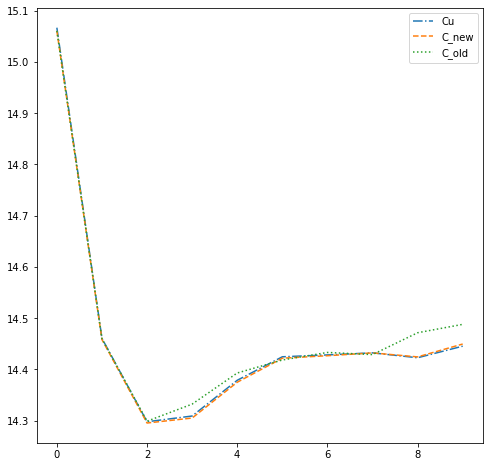

In [11]:
i = np.arange(0,len(SSDs[0]),1)
fig = plt.figure(figsize=(8,8))
plt.plot(i, SSDs[0], label = "Cu",linestyle="-.")
plt.plot(i, SSDs[1], label = "C_new",linestyle="--")
plt.plot(i, SSDs[2], label = "C_old",linestyle=":")
plt.legend()
plt.show()

<tf.Tensor: shape=(), dtype=float32, numpy=14.446003>

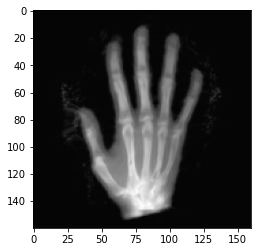

In [12]:
plt.imshow(warped_img,cmap='gray')
tf.reduce_sum((ref_img+hm-warped_img)**2)/2

In [13]:
print('PSNR',cv2.PSNR(np.uint8(ref_img*255),np.uint8(warped_img0*255),255))
print('PSNR+h',cv2.PSNR(np.uint8(ref_img*255),np.uint8(warped_img*255),255))
print('SSD',float(tf.reduce_sum((ref_img-warped_img0)**2)/2))
print('SSD+h',float(tf.reduce_sum((ref_img-warped_img)**2)/2))

PSNR 29.4707886017762
PSNR+h 29.481747765041618
SSD 14.485260009765625
SSD+h 14.450545310974121


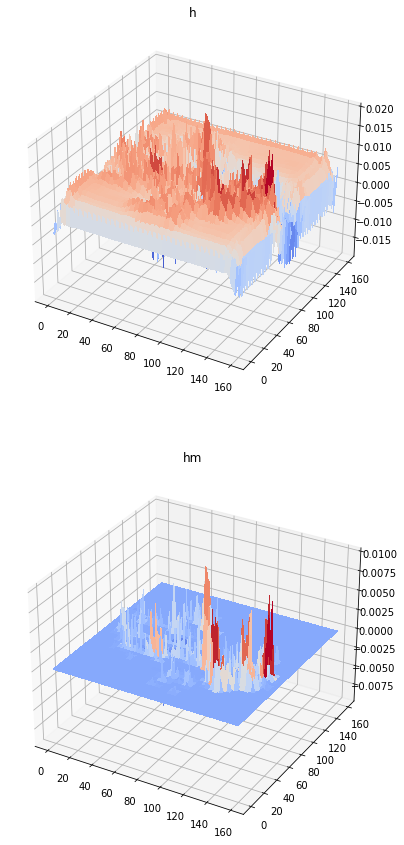

In [14]:
from matplotlib import cm
X = np.arange(0,shape,1)
Y = np.arange(0,shape,1)
Y, X = np.meshgrid(X, Y)
fig = plt.figure(figsize=(10,15))
u_1 = fig.add_subplot(211,projection='3d')
plt.title('h')
u_1.plot_surface(X, Y, h, cmap=cm.coolwarm,linewidth=0, antialiased=False)
u_2 = fig.add_subplot(212,projection='3d')
plt.title('hm')
u_2.plot_surface(X, Y, hm, cmap=cm.coolwarm,linewidth=0, antialiased=False)

In [ ]:
epochs_num = 10
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)

In [ ]:
heatmap_model.set_weights(Wsave) #reinitailize all weights
warped_img, T = diff_dem(ref_img,temp_img,500)
for _ in range(5):
    loss_value_old = 100
    for epoch in range(epochs_num):
        with tf.GradientTape() as tape:
            input_img = tf.expand_dims(tf.tile(tf.expand_dims(ref_img,-1),(1,1,3)),0)
            h = tf.squeeze(heatmap_model(input_img))
            h = h/np.max(abs(h))
            hm = hm_fn(h,step_t=1e-1,dc_eps=1)
            loss_value = tf.reduce_sum((ref_img+hm-warped_img)**2)/2
        grads = tape.gradient(loss_value, heatmap_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, heatmap_model.trainable_weights))
        print('learning loss',float(loss_value))
    print('Cu',float(loss_value))
    print('C',float(tf.reduce_sum((ref_img-warped_img)**2)/2),'\n')
    warped_img, T = diff_dem(ref_img+hm,temp_img,500,displacement_field=T)

In [ ]:
#plt.imshow(hm)
from matplotlib import cm
X = np.arange(0,shape,1)
Y = np.arange(0,shape,1)
Y, X = np.meshgrid(X, Y)
fig = plt.figure(figsize=(15,10))
u_1 = fig.add_subplot(111,projection='3d')
u_1.plot_surface(X, Y, h, cmap=cm.coolwarm,linewidth=0, antialiased=False)